# Group Details
## Group Name:
### Student 1:
### Student 2:
### Student 3:

In [220]:
import numpy as np
import matplotlib.pyplot as plt

In [221]:
%pip install tqdm
from tqdm import tqdm

Note: you may need to restart the kernel to use updated packages.


In [222]:
TRAIN = True

In [223]:
def load_trajectory(filename, task):

    traj = np.load(filename)
    if task == 'task_1' or task == 'task_2':
        trajectory = traj['trajectory']
        energy = traj['energy']
        return trajectory, energy
    if task == 'task_3':
        trajectory = traj['trajectory']
        framework = traj['framework']
        energy = traj['energy']
        return trajectory, framework, energy

Below, you can find an example of how to load a trajectory. ```trajectory``` contains the particle position, velocity and charge data. ```energy``` contains the energy of the system at various timesteps. The shape of the arrays is as follows:

```trajectory```: ```(time, n_bodies, [x, y, v_x, v_y, q])```

```energy```: ```(time, 1)```

In [224]:
trajectory, energy = load_trajectory('data/task1_2/train/trajectory_0.npz', 'task_1')
print(f'Trajectory shape: {trajectory.shape}, Energy shape: {energy.shape}')

Trajectory shape: (40, 4, 5), Energy shape: (40, 1)


In [225]:
x_0 = trajectory[0][0][0]
y_0 = trajectory[0][0][1]
print(f'Initial position: {x_0}, {y_0} Blue')

Initial position: 9.595544088638388, 7.531951993028981 Blue


The following code provides an example of how to visualize a trajectory. Feel free to modify this code, or write your own function. When evaluating your model in task 2 and 3, keep in mind that you are only allowed to use the data at t=0 (the black dots in the visualization).

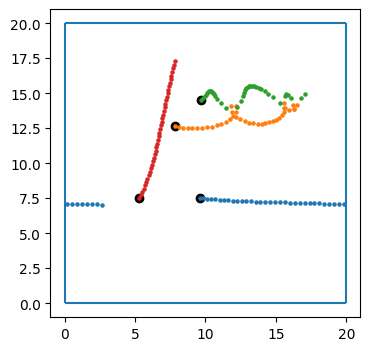

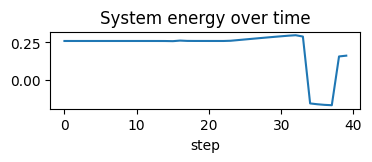

In [ ]:
def plot_trajectory_energy(trajectory, energy):
    x = trajectory[...,0]
    y = trajectory[...,1]

    plt.figure(figsize=(4,4))
    plt.vlines([0,20],0,20)
    plt.hlines([0,20],0,20)

    plt.scatter(x[0], y[0], c='black')

    for i in range(x.shape[1]):
        plt.scatter(x[:,i], y[:,i], s=5)

    plt.xlim(-1,21)
    plt.ylim(-1,21)

    plt.show()
    plt.figure(figsize=(4,1))
    plt.plot(energy)
    plt.xlabel('step')
    plt.title('System energy over time')
    plt.show();

plot_trajectory_energy(trajectory, energy)

# Task 1

Implement task 1 below. Feel free to add extra code cells for different components of your implementation.

In [ ]:
def preprocess_trajectory(trajectory):
    positions = trajectory[:, :, :2]  # Extract positions (x, y)
    velocities = trajectory[:, :, 2:4]  # Extract velocities (v_x, v_y)
    charges = trajectory[:, :, 4]  # Extract charges
    
    # Normalize positions to the range [0, 1]
    positions = positions / 20.0
    
    # Standardize velocities 
    velocities_mean = np.mean(velocities)
    velocities_std = np.std(velocities)
    velocities = (velocities - velocities_mean) / velocities_std
    
    return np.concatenate([positions, velocities, charges[:, :, np.newaxis]], axis=-1)

# Preprocess the sample trajectory
preprocessed_trajectory = preprocess_trajectory(trajectory)
print("Preprocessed trajectory shape:", preprocessed_trajectory.shape)


Preprocessed trajectory shape: (40, 4, 5)


In [ ]:
def preprocess_trajectory(trajectory, max_len, max_atoms):
    positions = trajectory[:, :, :2]  # Extract positions (x, y)
    velocities = trajectory[:, :, 2:4]  # Extract velocities (v_x, v_y)
    charges = trajectory[:, :, 4]  # Extract charges
    
    # Normalize positions to the range [0, 1]
    positions = positions / 20.0
    
    # Standardize velocities
    velocities_mean = np.mean(velocities)
    velocities_std = np.std(velocities)
    velocities = (velocities - velocities_mean) / velocities_std
    
    processed = np.concatenate([positions, velocities, charges[:, :, np.newaxis]], axis=-1)
    
    # Pad sequences to the maximum length and number of atoms
    if processed.shape[0] < max_len:
        pad_width = ((0, max_len - processed.shape[0]), (0, 0), (0, 0))
        processed = np.pad(processed, pad_width, mode='constant', constant_values=0)
    if processed.shape[1] < max_atoms:
        pad_width = ((0, 0), (0, max_atoms - processed.shape[1]), (0, 0))
        processed = np.pad(processed, pad_width, mode='constant', constant_values=0)
    
    return processed

# Preprocess the sample trajectory
max_len = 40  # Sequence length is 40
max_atoms = 5  # The maximum number of atoms is 5
preprocessed_trajectory = preprocess_trajectory(trajectory, max_len, max_atoms)
print("Preprocessed trajectory shape:", preprocessed_trajectory.shape)


Preprocessed trajectory shape: (40, 5, 5)


In [ ]:
from sklearn.model_selection import train_test_split
import glob
import torch
from torch.utils.data import DataLoader, Dataset

class MolecularDynamicsDataset(Dataset):
    def __init__(self, file_paths, task, max_len, max_atoms):
        self.file_paths = file_paths
        self.task = task
        self.max_len = max_len
        self.max_atoms = max_atoms
        self.data = [self.load_and_preprocess(file_path) for file_path in file_paths]
    
    def load_and_preprocess(self, file_path):
        trajectory, energy = load_trajectory(file_path, self.task)
        return preprocess_trajectory(trajectory, self.max_len, self.max_atoms), energy
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        trajectory, energy = self.data[idx]
        return torch.tensor(trajectory, dtype=torch.float32), torch.tensor(energy, dtype=torch.float32)

# Determine the maximum length of the trajectories
file_paths = glob.glob('data/task1_2/train/*.npz')
max_len = max([load_trajectory(fp, 'task_1')[0].shape[0] for fp in file_paths])
max_atoms = 5  # The number of atoms can be 3, 4, or 5

# Create datasets
train_file_paths, val_file_paths = train_test_split(file_paths, test_size=0.2, random_state=42)
train_dataset = MolecularDynamicsDataset(train_file_paths, 'task_1', max_len, max_atoms)
val_dataset = MolecularDynamicsDataset(val_file_paths, 'task_1', max_len, max_atoms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
import torch.nn as nn
import torch.optim as optim

class MolecularDynamicsModel(nn.Module):
    def __init__(self, max_len, max_atoms):
        super(MolecularDynamicsModel, self).__init__()
        self.max_len = max_len
        self.max_atoms = max_atoms
        self.lstm = nn.LSTM(input_size=5, hidden_size=64, num_layers=1, batch_first=True)
        self.dense1 = nn.Linear(64 * max_atoms, 256)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(256, 40)  # Output 40 energy values, one for each time point
    
    def forward(self, x):
        # Reshape from (batch_size, time_steps, n_atoms, feature_size) to (batch_size * n_atoms, time_steps, feature_size)
        batch_size, time_steps, n_atoms, feature_size = x.size()
        x = x.view(batch_size * n_atoms, time_steps, feature_size)
        
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Get the output from the last time step
        
        # Reshape back to (batch_size, n_atoms, hidden_size)
        lstm_out = lstm_out.view(batch_size, n_atoms, -1)
        lstm_out = lstm_out.contiguous().view(batch_size, -1)  # Flatten the last two dimensions
        
        out = self.dense1(lstm_out)
        out = self.relu(out)
        out = self.dense2(out)
        return out

# Initialize the model
model = MolecularDynamicsModel(max_len=max_len, max_atoms=max_atoms)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0
    progress_bar = tqdm(train_loader, desc='Training', total=len(train_loader))
    for trajectories, energies in progress_bar:
        trajectories, energies = trajectories.to(device), energies.to(device)
        
        optimizer.zero_grad()
        outputs = model(trajectories)
        
        # Squeeze the energies tensor to remove the last dimension
        energies = energies.squeeze(-1)
        
        loss = criterion(outputs, energies)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * trajectories.size(0)
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(trajectories))})
    
    return train_loss / len(train_loader.dataset)

def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    progress_bar = tqdm(val_loader, desc='Validation', total=len(val_loader))
    with torch.no_grad():
        for trajectories, energies in progress_bar:
            trajectories, energies = trajectories.to(device), energies.to(device)
            
            outputs = model(trajectories)
            
            # Squeeze the energies tensor to remove the last dimension
            energies = energies.squeeze(-1)
            
            loss = criterion(outputs, energies)
            
            val_loss += loss.item() * trajectories.size(0)
            progress_bar.set_postfix({'validation_loss': '{:.3f}'.format(loss.item()/len(trajectories))})
    
    return val_loss / len(val_loader.dataset)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MolecularDynamicsModel(
  (lstm): LSTM(5, 64, batch_first=True)
  (dense1): Linear(in_features=320, out_features=256, bias=True)
  (relu): ReLU()
  (dense2): Linear(in_features=256, out_features=40, bias=True)
)

In [ ]:
num_epochs = 200

if TRAIN:
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train_loss = train(model, train_loader, criterion, optimizer, device)
        val_loss = validate(model, val_loader, criterion, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Save the model if the validation loss decreased
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


In [ ]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

if TRAIN:
    plot_losses(train_losses, val_losses)

In [ ]:
# Load the best model
model = MolecularDynamicsModel(max_len=max_len, max_atoms=max_atoms)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

MolecularDynamicsModel(
  (lstm): LSTM(5, 64, batch_first=True)
  (dense1): Linear(in_features=320, out_features=256, bias=True)
  (relu): ReLU()
  (dense2): Linear(in_features=256, out_features=40, bias=True)
)

In [247]:
# Load and preprocess test data
test_file_paths = glob.glob('data/task1_2/test/*.npz')
test_dataset = MolecularDynamicsDataset(test_file_paths, 'task_1', max_len, max_atoms)
test_loader = DataLoader(test_dataset, batch_size=40, shuffle=False)

In [ ]:
import numpy as np

def compute_trajectory_mse(model, data_loader, device):
    model.eval()
    mse_values = []

    with torch.no_grad():
        for trajectories, energies in data_loader:
            trajectories, energies = trajectories.to(device), energies.to(device)
            
            outputs = model(trajectories)
            
            # Remove the singleton dimension from energies
            energies = energies.squeeze(-1)
            
            # Calculate the squared differences
            squared_diff = (outputs - energies) ** 2
            squared_diff = squared_diff.cpu().numpy()
            
            # Print the shape of squared_diff for debugging
            print("Shape of squared_diff array:", squared_diff.shape)
            
            # Compute the MSE for each data point in the trajectory
            mse_trajectory = np.mean(squared_diff, axis=1)
            
            # Append the MSE to the list
            mse_values.extend(mse_trajectory.tolist())

    # return mean of mse_values
    return np.mean(mse_values)


compute_trajectory_mse(model, test_loader, device)


Shape of squared_diff array: (40, 40)
Shape of squared_diff array: (40, 40)
Shape of squared_diff array: (20, 40)


1.015270452001132

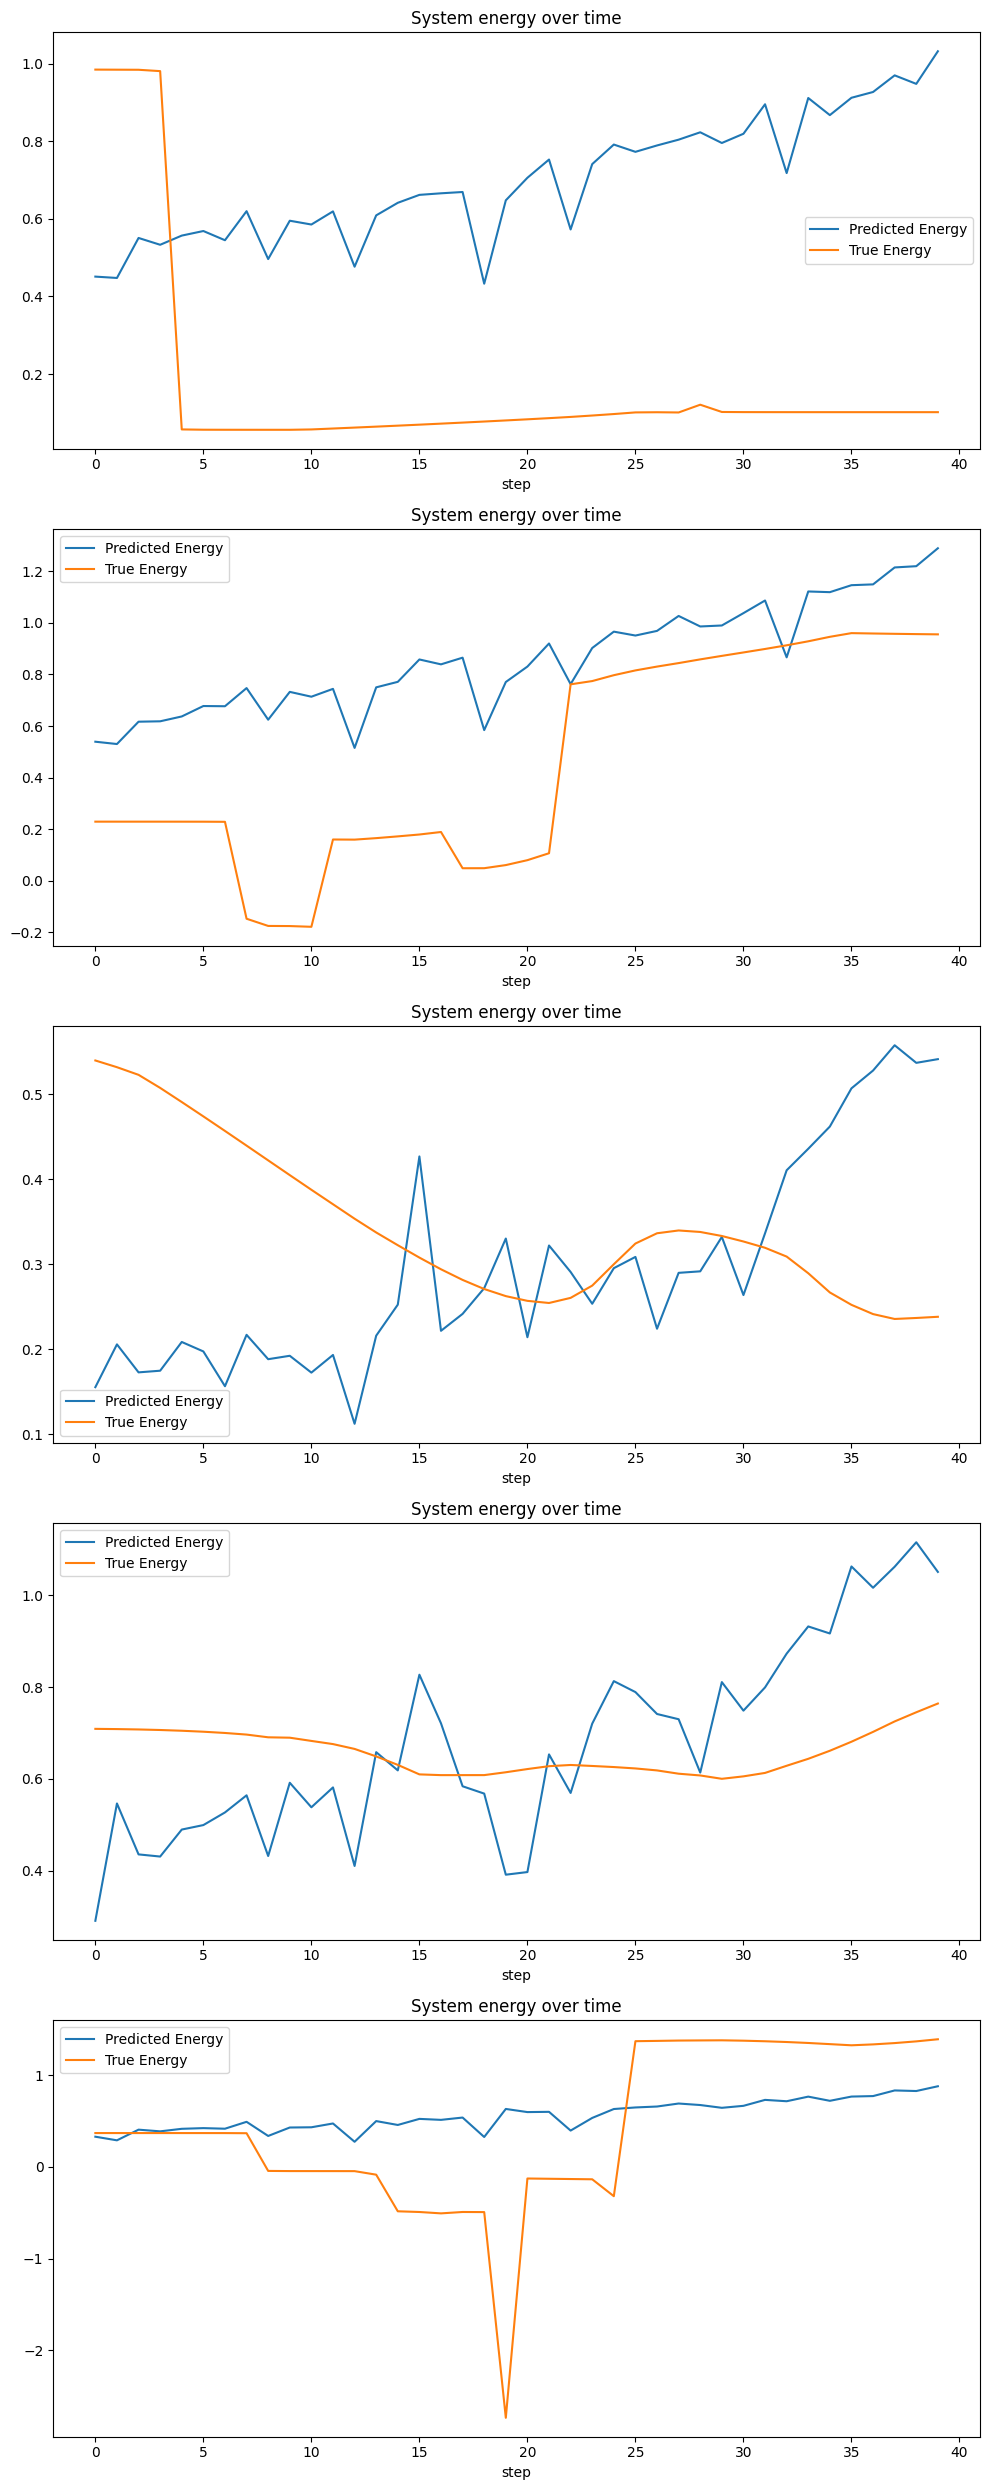

In [ ]:
def plot_predictions(model, data_loader, device, num_plots=5):
    model.eval()
    random_indices = np.random.randint(0, len(data_loader.dataset), size=num_plots)

    fig, axs = plt.subplots(num_plots, 1, figsize=(10, num_plots*5))

    with torch.no_grad():
        plot_count = 0
        for i, (trajectories, energies) in enumerate(data_loader.dataset):
            if i not in random_indices:
                continue
            trajectories, energies = trajectories.to(device), energies.to(device)
            
            outputs = model(trajectories.unsqueeze(0))
            
            # Plot predicted energies
            axs[plot_count].plot(outputs[0].cpu().numpy(), label='Predicted Energy')

            # Plot true energies
            axs[plot_count].plot(energies.cpu().numpy().flatten(), label='True Energy')

            axs[plot_count].set_xlabel('step')
            axs[plot_count].set_title('System energy over time')
            axs[plot_count].legend()

            plot_count += 1
            if plot_count == num_plots:
                break

    plt.tight_layout()
    plt.show()

plot_predictions(model, test_loader, device, num_plots=5)

# Task 2

Implement task 2 below. Feel free to add extra code cells for different components of your implementation.

# Task 3

In task 3, you also need to model the influences of the crystal. An example of loading a trajectory can be found below. The trajectory and energy data has the same shape as before, however, data regarding the crystal has been added. Since atoms belonging to the crystal do not move, this data does not have a time dimension when loaded. The shapes of the arrays are as follows:

```trajectory```: ```(time, n_bodies, [x, y, v_x, v_y, q])```

```energy```: ```(time, 1)```

```framework```:```(n_framework_atom, [x, y, q])```



In [ ]:
trajectory, framework, energy = load_trajectory('data/task3/train/trajectory_0.npz', 'task_3')
print(f'Trajectory shape: {trajectory.shape}, Framework shape: {framework.shape}, Energy shape: {energy.shape}')

Trajectory shape: (40, 4, 5), Framework shape: (20, 3), Energy shape: (40, 1)


The following code provides an example of how to visualize a trajectory with a crystal. Feel free to modify this code, or write your own function. When evaluating your model in this task, keep in mind that you are only allowed to use the data at t=0 (the black dots in the visualization).

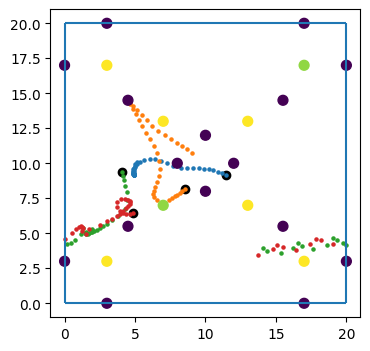

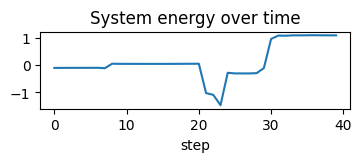

In [ ]:
x = trajectory[...,0]
y = trajectory[...,1]

x_fw = framework[...,0]
y_fw = framework[...,1]
q_fw = framework[...,2]

plt.figure(figsize=(4,4))
plt.vlines([0,20],0,20)
plt.hlines([0,20],0,20)

plt.scatter(x[0], y[0], c='black')

for i in range(x.shape[1]):
    plt.scatter(x[:,i], y[:,i], s=5)

plt.scatter(x_fw, y_fw, c=q_fw, cmap='viridis', s=50)
# to also visualize the framework points along the boundaries
plt.scatter(x_fw+20, y_fw, c=q_fw, cmap='viridis', s=50)
plt.scatter(x_fw, y_fw+20, c=q_fw, cmap='viridis', s=50)
plt.scatter(x_fw+20, y_fw+20, c=q_fw, cmap='viridis', s=50)

plt.xlim(-1,21)
plt.ylim(-1,21)

plt.show()
plt.figure(figsize=(4,1))
plt.plot(energy)
plt.xlabel('step')
plt.title('System energy over time')
plt.show();

Implement task 3 below. Feel free to add extra code cells for different components of your implementation.